In [2]:
# import statements
from Tools.toolbox import *
from Tools.functions import *
import csv
from scipy.stats import ks_2samp
import pandas as pd

In [3]:
dates_ebola = []
countries_ebola = []
with open('data/ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

In [4]:
date_nums_guinea = [convert_date_to_numberB(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_numberB(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_numberB(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_numberB(date, dates_all[0]) for date in dates_all]

In [6]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
observed_all = distribute(date_nums_all)

In [7]:
def optimized_paras(event_times, T):
    n = binary_search(event_times, T)
    paras = [0.72306694, 0.72543727, 0.11557651]
    bnds = ((0.001, 2), (0.001, 2), (0.01, 1))
    intensity = lambda t, paras: intensity_constructor(t, paras, event_times, ExpKernel, ConstBase, depth=30)
    result = MLE_de(intensity, event_times[:n], model="constexp", bounds=bnds, maxiter=10)
    optimized_paras_T = result.x
    return optimized_paras_T

optimized_paras(observed_all, 150)

array([0.25752527, 0.30160225, 0.34684554])

In [20]:
def simulation_plots(paras, event_times, dates, T):
    #Get simulations
    n = binary_search(event_times, T)
    samples_branching = []
    for _ in range(1000):
        samples_branching.append(simulate_cluster_structure(ExpKernel(*paras[:2]), ConstBase(paras[-1]), event_times[:n], T/0.8))
    
    #plot cumulative frequency simulations
    plt.rcParams['font.size'] = 15
    N = binary_search(event_times, T/0.8)
    for sample in samples_branching:
        plt.plot(sample, range(len(sample)), color="k", alpha=0.02)
    plt.plot(event_times[:N], range(N), color='r')
    plt.xlabel("Days")
    plt.ylabel("Cumulative frequency")
    plt.show()

    #plot daily frequency simulations
    times = dates[:N]
    count = Counter(times)
    keys = count.keys()
    values = [count[key] for key in keys]
    plt.plot(keys, values, color = 'r')

    for sample in samples_branching:
        times = np.floor(sample[n:])
        count = Counter(times)
        keys = count.keys()
        values = [count[key] for key in keys]
        plt.scatter(keys, values, color='k', marker='x', s=30, alpha=0.005)

    plt.xlabel('Days')
    plt.ylabel('Daily frequency')
    plt.show()


In [21]:
def simulation(country, T):
    if country == "Guinea":
        event_times = observed_guinea
        date_nums = date_nums_guinea
    elif country == "Liberia":
        event_times = observed_liberia
        date_nums = date_nums_liberia
    elif country == "Sierra Leone":
        event_times = observed_sierra
        date_nums = date_nums_sierra
    optimized_params = optimized_paras(event_times, T)
    print(f"The parameters fitted to the first {T} days in {country} are {optimized_params}")
    simulation_plots(optimized_params, event_times, date_nums, T)


The parameters fitted to the first 150 days in Guinea are [0.24069017 0.28654662 0.33499886]


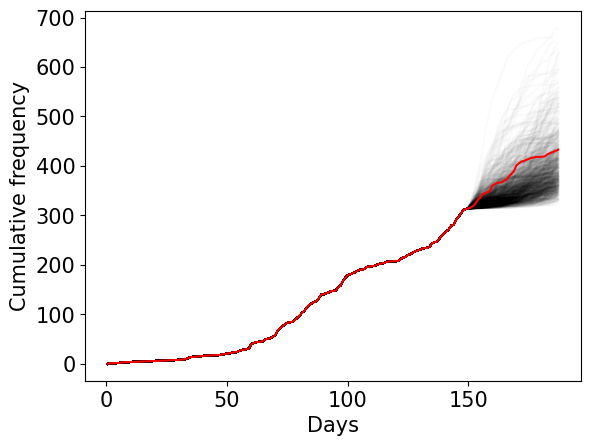

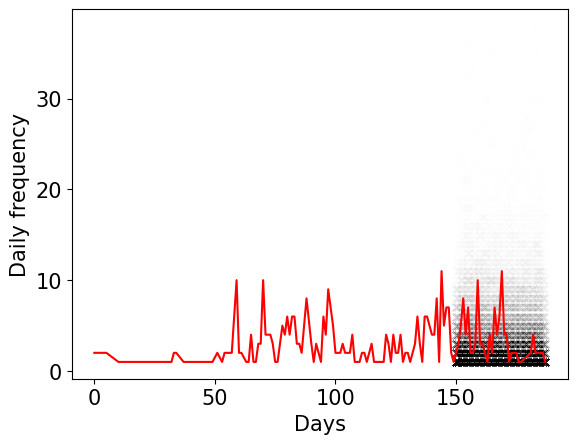

The parameters fitted to the first 300 days in Guinea are [0.37146355 0.39283748 0.30415137]


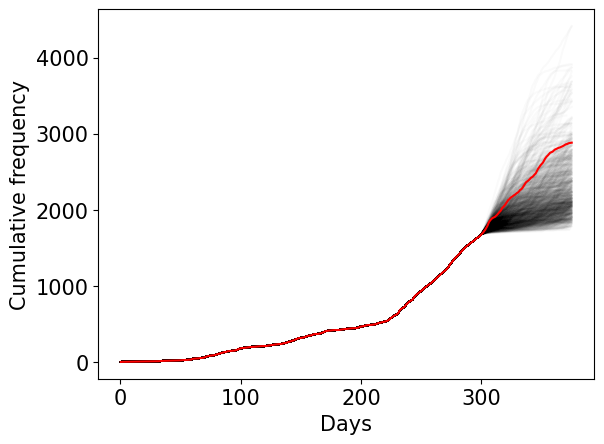

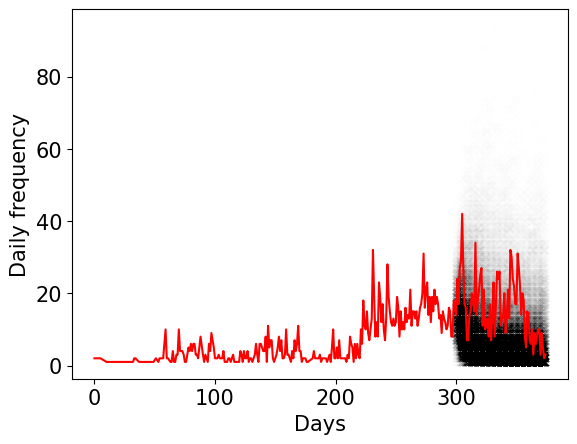

The parameters fitted to the first 450 days in Guinea are [0.48915034 0.51084546 0.32692136]


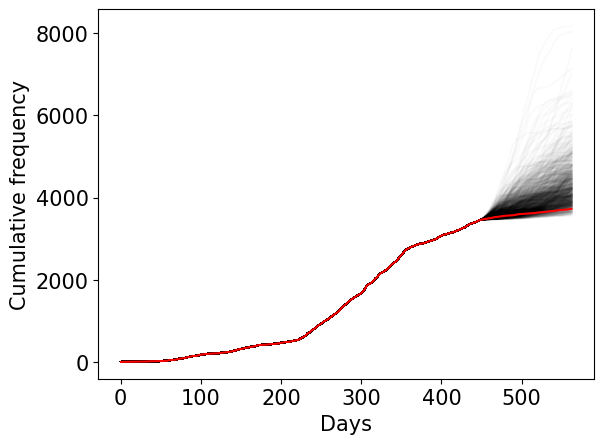

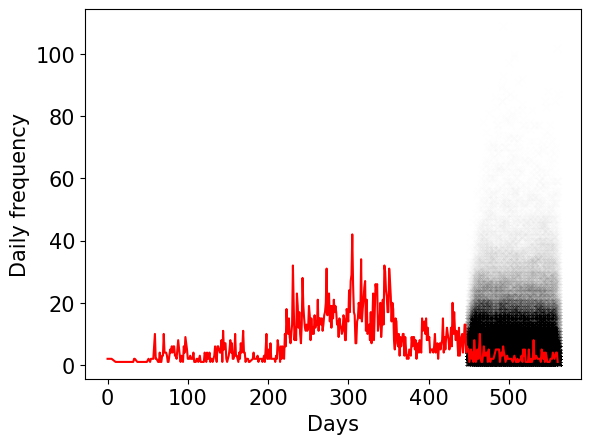

In [22]:
simulation("Guinea", 150)
simulation("Guinea", 300)
simulation("Guinea", 450)


The parameters fitted to the first 100 days in Liberia are [0.001      0.00508706 0.40275093]


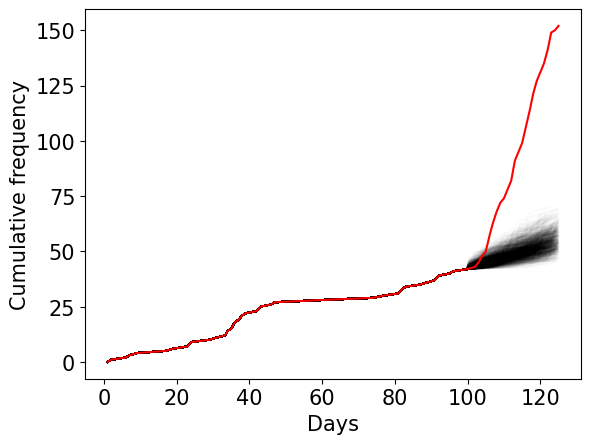

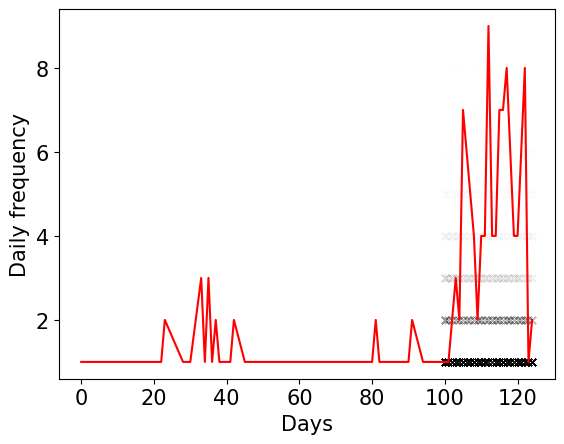

The parameters fitted to the first 200 days in Liberia are [0.68153803 0.68852645 0.20850725]


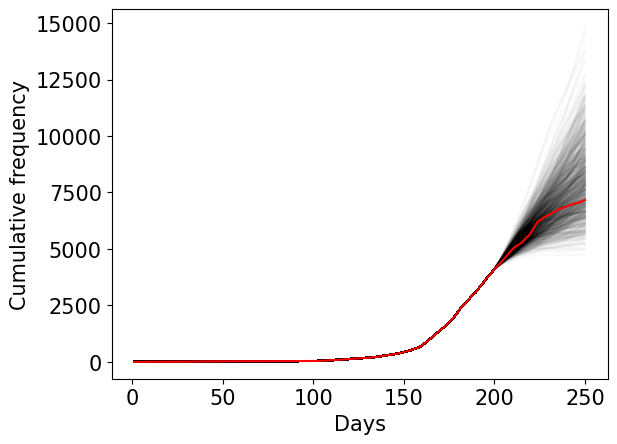

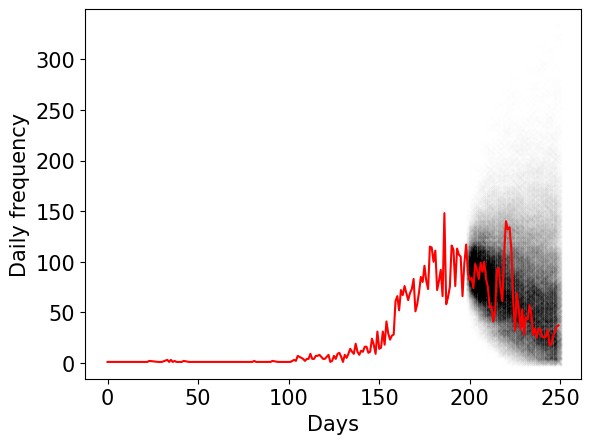

The parameters fitted to the first 300 days in Liberia are [0.95602081 0.96416418 0.22474829]


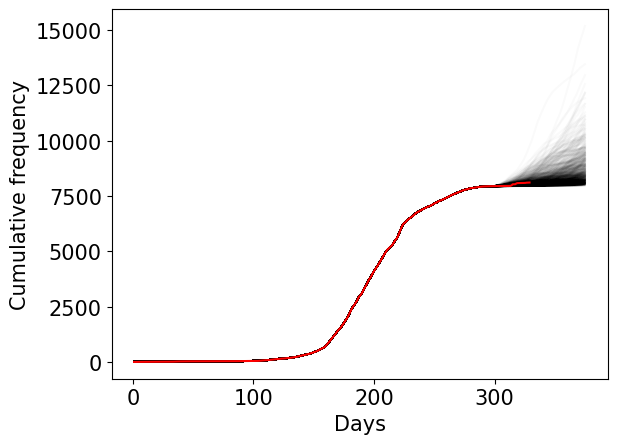

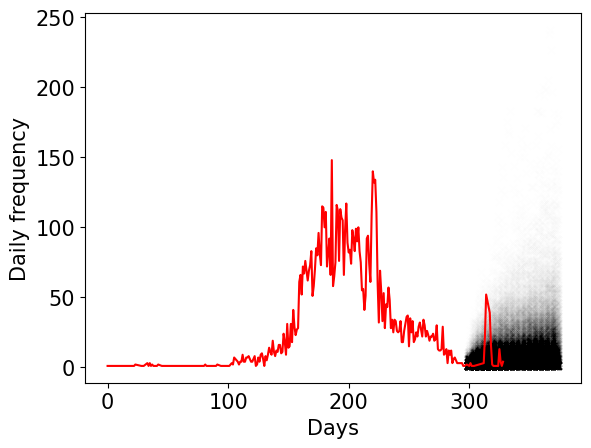

In [23]:
simulation("Liberia", 100)
simulation("Liberia", 200)
simulation("Liberia", 300)

The parameters fitted to the first 150 days in Sierra Leone are [0.001      0.00556069 0.22677197]


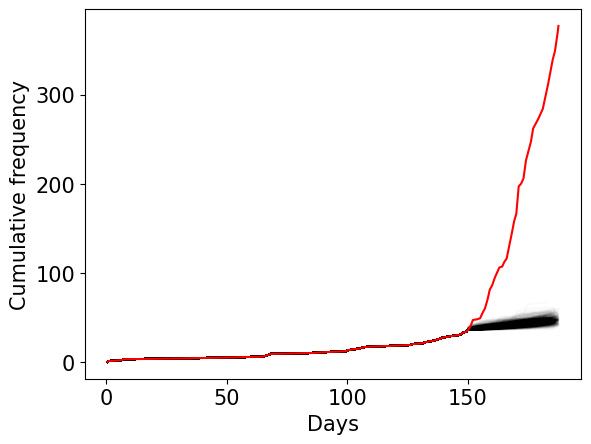

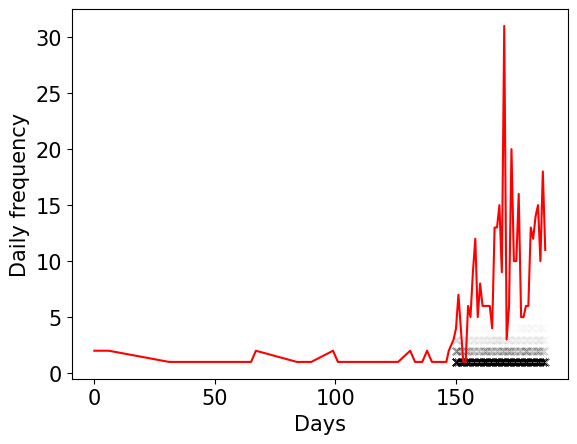

The parameters fitted to the first 300 days in Sierra Leone are [0.84330907 0.84893691 0.12144915]


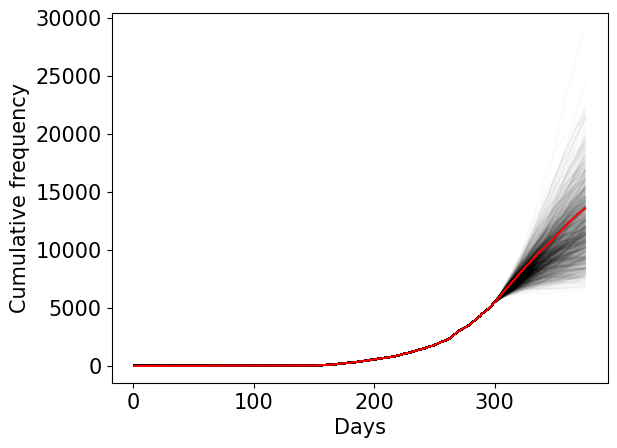

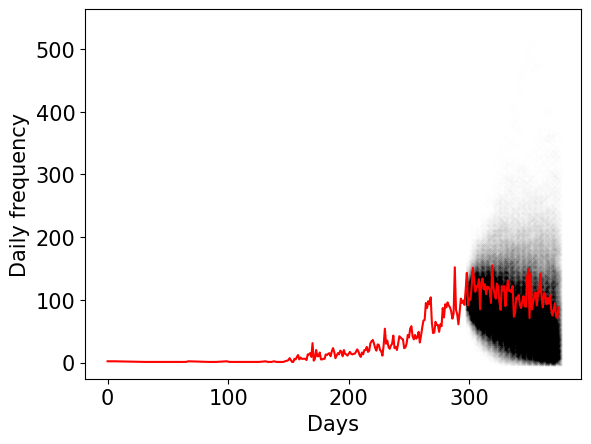

The parameters fitted to the first 450 days in Sierra Leone are [0.72602306 0.72821862 0.11602739]


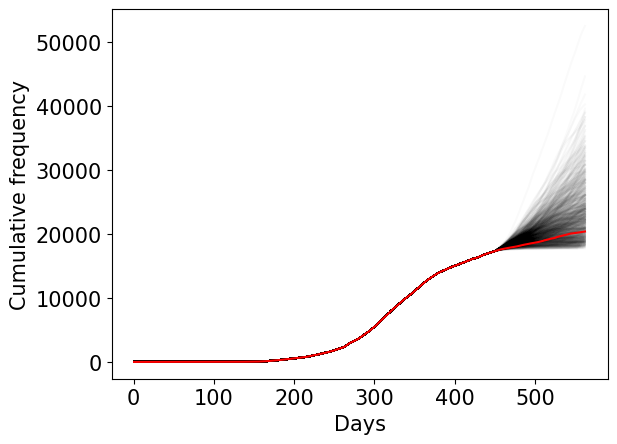

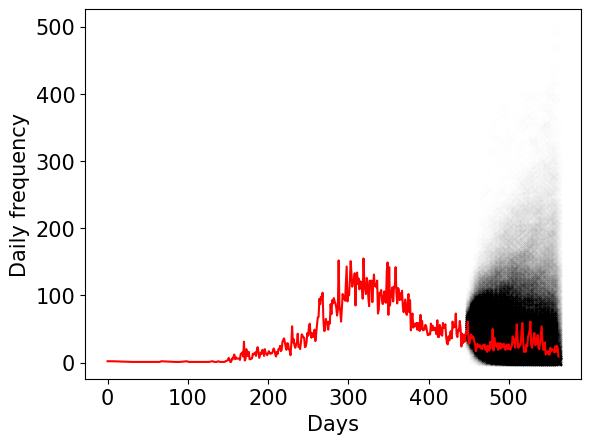

In [24]:
simulation("Sierra Leone", 150)
simulation("Sierra Leone", 300)
simulation("Sierra Leone", 450)